<a href="https://colab.research.google.com/github/AdamNur422/nlpProj/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import csv
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import Constant


import pprint
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [ ]:
data = pd.read_csv("news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
data.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [ ]:
data.shape

(6335, 4)

In [ ]:
data = data.drop('Unnamed: 0', axis=1)

In [ ]:
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Encoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(data['label'])
data['label'] = le.transform(data['label'])
data

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


<ipython-input-9-75ad016e7f7e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='rocket')


<Axes: xlabel='label', ylabel='count'>

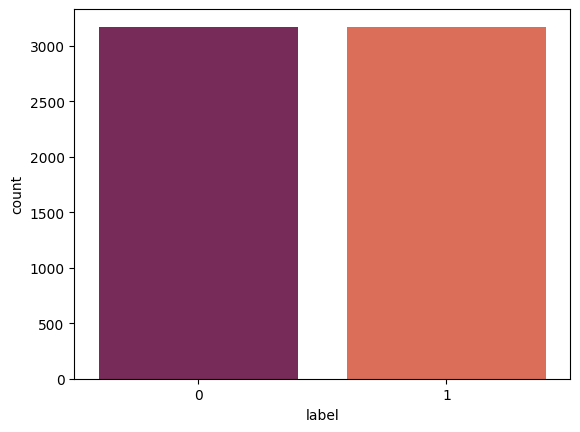

In [ ]:
label_map = {0: 'Fake', 1: 'Real'}
sns.countplot(x='label', data=data, palette='rocket')

Params

In [ ]:
embedding_dim = 50
max_length = 54
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 3000    # training
test_portion = .1       # testing


In [ ]:
# extract data
title = []
text = []
labels = []

title = data['title'].tolist()[:training_size]
text = data['text'].tolist()[:training_size]
labels = data['label'].tolist()[:training_size]


In [ ]:
print(len(title))
print(len(text))
print(len(labels))

3000
3000
3000


Tokenization

In [ ]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(title)
word_index1 = tokenizer1.word_index
vocab_size1 = len(word_index1)

sequences1 = tokenizer1.texts_to_sequences(title)

# make sure there the same length
padded1 = pad_sequences(sequences1,  padding=padding_type, truncating=trunc_type)

In [ ]:
split = int(test_portion * training_size)
training_sequences1 = padded1[split:training_size]  # Training data
test_sequences1 = padded1[:split]                   # Testing data
training_labels = labels[split:training_size]       # Training labels
test_labels = labels[:split]                        # Testing labels

Embedding

In [ ]:
embeddings_index = {}

# file for predefined vector space for words
with open('glove.6B.50d.txt', encoding='utf-8') as f:
	for line in f:
		values = line.split()
		word = values[0]
		coefs = np.asarray(values[1:], dtype='float32')
		embeddings_index[word] = coefs

# embeddings
embeddings_matrix = np.zeros((vocab_size1+1, embedding_dim))
for word, i in word_index1.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embeddings_matrix[i] = embedding_vector

Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size1 + 1, embedding_dim,
                              input_length=max_length,
                              embeddings_initializer=Constant(embeddings_matrix),
                              trainable=False,
                              input_shape=(max_length,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 50)            377600    
                                                                 
 dropout (Dropout)           (None, 54, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            16064     
                                                                 
 max_pooling1d (MaxPooling1  (None, 12, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

Training

In [ ]:
num_epochs = 50

training_padded = np.array(training_sequences1)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences1)
testing_labels = np.array(test_labels)

In [ ]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50
85/85 - 8s - loss: 0.6423 - accuracy: 0.6178 - val_loss: 0.5756 - val_accuracy: 0.6833 - 8s/epoch - 92ms/step
Epoch 2/50
85/85 - 3s - loss: 0.5881 - accuracy: 0.6915 - val_loss: 0.5480 - val_accuracy: 0.7100 - 3s/epoch - 31ms/step
Epoch 3/50
85/85 - 2s - loss: 0.5425 - accuracy: 0.7293 - val_loss: 0.5180 - val_accuracy: 0.7167 - 2s/epoch - 25ms/step
Epoch 4/50
85/85 - 2s - loss: 0.4853 - accuracy: 0.7681 - val_loss: 0.5104 - val_accuracy: 0.7267 - 2s/epoch - 25ms/step
Epoch 5/50
85/85 - 2s - loss: 0.4513 - accuracy: 0.7930 - val_loss: 0.5020 - val_accuracy: 0.7167 - 2s/epoch - 25ms/step
Epoch 6/50
85/85 - 2s - loss: 0.3985 - accuracy: 0.8130 - val_loss: 0.5393 - val_accuracy: 0.7400 - 2s/epoch - 25ms/step
Epoch 7/50
85/85 - 4s - loss: 0.3371 - accuracy: 0.8556 - val_loss: 0.5200 - val_accuracy: 0.7567 - 4s/epoch - 42ms/step
Epoch 8/50
85/85 - 3s - loss: 0.3069 - accuracy: 0.8707 - val_loss: 0.6381 - val_accuracy: 0.7400 - 3s/epoch - 33ms/step
Epoch 9/50
85/85 - 2s - loss: 0.

In [ ]:
predictions = model.predict(testing_padded)
predicted_labels = (predictions > 0.5).astype(int)

10/10 [==============================] - 0s 7ms/step


In [ ]:
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

report = classification_report(test_labels, predicted_labels, target_names=['Fake', 'Real'])
print("Classification Report:")
print(report)

Accuracy: 0.7400
Classification Report:
              precision    recall  f1-score   support

        Fake       0.75      0.68      0.72       144
        Real       0.73      0.79      0.76       156

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300



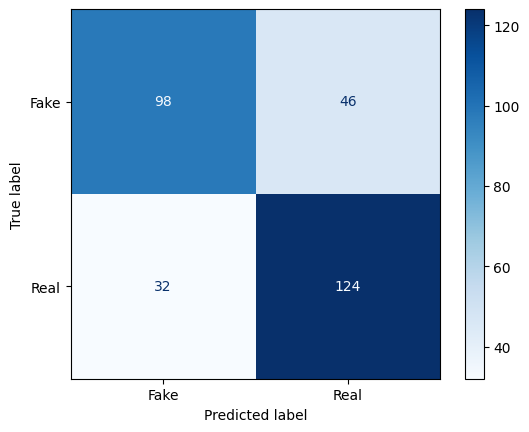

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
X = "AI can be easily used to make fake election photos - report"

sequences = tokenizer1.texts_to_sequences([X])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = model.predict(padded_sequences, verbose=0)[0][0]

if prediction >= 0.5:
    print("This news is True")
else:
    print("This news is False")

This news is False
